In [25]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import style
style.use('ggplot')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [26]:
TRAIN_SET_FILE = '../input/train/2017-01-01 00:00:00.csv'
TEST_SET_FILE = '../input/test/2017-01-01 00:00:00.csv'
train_df = pd.read_csv(TRAIN_SET_FILE,index_col=0)
test_df = pd.read_csv(TEST_SET_FILE,index_col=0)
train_df.shape,test_df.shape

((17462, 74), (10897, 74))

In [27]:
# def create_shift_features(data,shift_columns,offsets,periods):
#     for i in range(1,len(shift_columns)+1):
#         column,offset,period = shift_columns[i-1],offsets[i-1],periods[i-1]
#         for j in range(1,period+1):
#             data[f'{column}_shift{offset}_{j}'] = data[column].shift((offset+j))
#     return data

# columns = ['xiaoxi_out','xiaoxi_out_day_avg','zhexi_in','zhexi_in_day_avg']
# offsets=[0,0,48,48]
# periods=[12,12,12,12]
# create_shift_features(df,shift_columns=columns,offsets=offsets,periods=periods)

In [28]:
# print(df.shape)
# df = df.dropna()
# print(df.shape)

In [29]:
from sklearn.linear_model import BayesianRidge,Ridge,RidgeCV,LinearRegression,ElasticNet,ElasticNetCV
from sklearn.linear_model import Lasso,LassoCV,LassoLars,LassoLarsCV
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor,VotingRegressor
from xgboost import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor
import gbdtpl

from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV,train_test_split,KFold

## create a baseline, using the default model params

In [30]:
# train_set = df[:'2015-11-01 23:00:00']
# test_set = df['2015-11-02 0:00:00':]

test_x,test_y = np.array(test_df[test_df.columns[1:]]),np.array(test_df[test_df.columns[0]])
train_x,val_x,train_y,val_y = train_test_split(np.array(train_df[train_df.columns[1:]]),
                                                 np.array(train_df[train_df.columns[0]]),test_size=0.2,random_state=20)
reg_br = BayesianRidge()
reg_ridge = Ridge()
reg_ridgecv = RidgeCV(cv=10)
reg_lr = LinearRegression()
reg_en = ElasticNet()
reg_encv = ElasticNetCV(cv=10)
reg_lasso = Lasso()
reg_lassocv = LassoCV()
reg_lars = LassoLars()
reg_larscv = LassoLarsCV()

reg_ada = AdaBoostRegressor()
reg_gb = GradientBoostingRegressor()
reg_et = ExtraTreesRegressor()
reg_rf = RandomForestRegressor()

reg_xgb = XGBRegressor(objective="reg:squarederror")
reg_lgb = LGBMRegressor()
reg_cat = CatBoostRegressor()

reg_bag1 = BaggingRegressor()
reg_bag2 = BaggingRegressor(base_estimator=reg_ada)
reg_bag3 = BaggingRegressor(base_estimator=reg_gb)
reg_bag4 = BaggingRegressor(base_estimator=reg_et)
reg_bag5 = BaggingRegressor(base_estimator=reg_rf)
reg_bag6 = BaggingRegressor(base_estimator=reg_xgb)
reg_bag7 = BaggingRegressor(base_estimator=reg_lgb)
reg_bag8 = BaggingRegressor(base_estimator=reg_cat)

reg_svm = LinearSVR()
reg_knn = KNeighborsRegressor(n_neighbors=15)
import lstm
lstm.INPUT_DIM = train_df.shape[-1]
reg_lstm = lstm.make_model(lstm_units=60)

linear_models = []
linear_models.append(('reg_br',reg_br))
linear_models.append(('reg_ridge',reg_ridge))
linear_models.append(('reg_ridgecv',reg_ridgecv))
linear_models.append(('reg_lr',reg_lr))
linear_models.append(('reg_encv',reg_encv))
linear_models.append(('reg_lassocv',reg_lassocv))
linear_models.append(('reg_larscv',reg_larscv))
reg_vote1 = VotingRegressor(estimators=linear_models)

tree_based_models = []
tree_based_models.append(('reg_ada',reg_ada))
tree_based_models.append(('reg_gb',reg_gb))
tree_based_models.append(('reg_et',reg_et))
tree_based_models.append(('reg_rf',reg_rf))
tree_based_models.append(('reg_xgb',reg_xgb))
tree_based_models.append(('reg_lgb',reg_lgb))
tree_based_models.append(('reg_cat',reg_cat))
reg_vote2 = VotingRegressor(estimators=tree_based_models)

bagging_models = []
bagging_models.append(('reg_bag1',reg_bag1))
bagging_models.append(('reg_bag2',reg_bag2))
bagging_models.append(('reg_bag3',reg_bag3))
bagging_models.append(('reg_bag4',reg_bag4))
bagging_models.append(('reg_bag5',reg_bag5))
bagging_models.append(('reg_bag6',reg_bag6))
bagging_models.append(('reg_bag7',reg_bag7))
bagging_models.append(('reg_bag8',reg_bag8))
reg_vote3 = VotingRegressor(estimators=bagging_models)

vote_models = []
vote_models.append(('reg_vote1',reg_vote1))
vote_models.append(('reg_vote2',reg_vote2))
vote_models.append(('reg_vote3',reg_vote3))

other_models = []
other_models.append(('reg_svm',reg_svm))
other_models.append(('reg_knn',reg_knn))

lstm_models = []
lstm_models.append(('reg_lstm',reg_lstm))

In [31]:
def fit_models(models,x,y):
    for i in range(len(models)):
        print(models[i][1])
        if(models[i][0] is 'reg_lstm'):
            x = x.reshape(-1,1,lstm.INPUT_DIM)
            models[i][1].fit(x,y, epochs=15, batch_size=128)
        else:
            models[i][1].fit(x,y)
def plot_result(models,x,y,ouput_file_name):
    plt.figure(figsize=(16,6))
    results = pd.DataFrame()
    results['real_value'] = pd.Series(y)
    for i in range(len(models)):
        name,reg = models[i]
        if(name is 'reg_lstm'):
            x = x.reshape(-1,1,lstm.INPUT_DIM)
        y_hat = reg.predict(x)
        results[name] = pd.Series(np.array(y_hat).reshape(-1))
        mse = mean_squared_error(y_hat,y)
        plt.subplot(len(models)/3 + 1,3,i+1)
        plt.plot(y_hat)
        plt.plot(y)
        plt.title(f'reg: {name} mse: {np.round(mse,5)}')
    plt.savefig(f'../output/plot/{ouput_file_name}.png',dpi=100)
    plt.show()
    results.to_csv(f'../output/predict_csv/{ouput_file_name}.csv')
    
def fit_predict_plot(models,train_x,train_y,test_x,test_y,ouput_file_name):
    fit_models(models,train_x,train_y)
    plot_result(models,test_x,test_y,ouput_file_name)


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=10, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)
LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,

/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoLarsCV(copy_X=True, cv='warn', eps=2.220446049250313e-16,
            fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=None,
            normalize=True, positive=False, precompute='auto', verbose=False)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/harrison/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


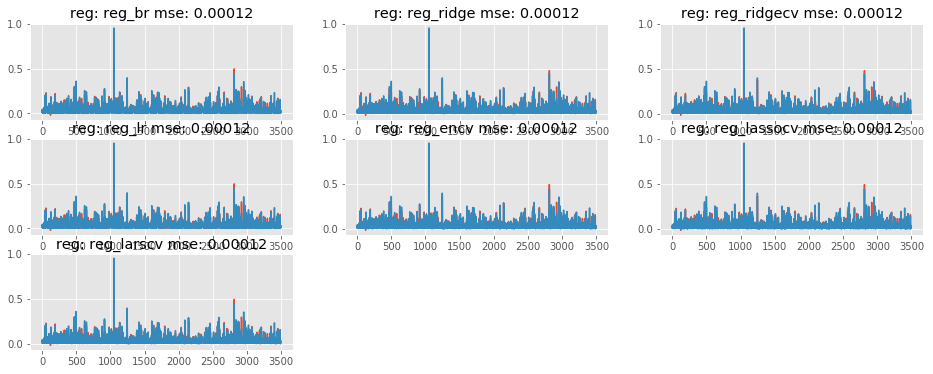

In [37]:
fit_predict_plot(linear_models,train_x,train_y,val_x,val_y,'linear_models_val')

/home/harrison/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


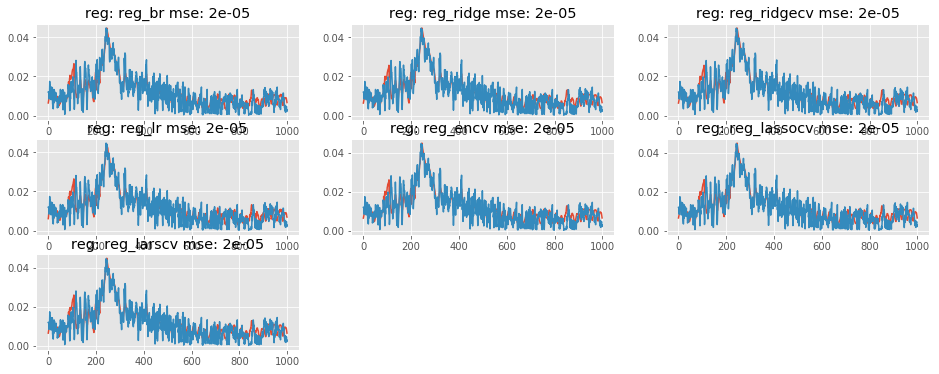

In [40]:
# x = np.array(test_set[test_set.columns[1:]])
# y = np.array(test_set[test_set.columns[0]])
plot_result(linear_models,test_x[:1000],test_y[:1000],'linear_models_pre')

In [46]:
import glob

In [79]:
results = pd.DataFrame()
files = glob.glob('../output/predict_csv/*pre.csv')
for file in [files[0]]:
    df = pd.read_csv(file,index_col=0)
    results[df.columns] = df[df.columns]
results['mean'] = pd.Series(np.mean(results[results.columns[1:]],axis=1))

In [80]:
mean_squared_error(results['mean'],results['real_value'])

0.0009755826100248455

/home/harrison/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


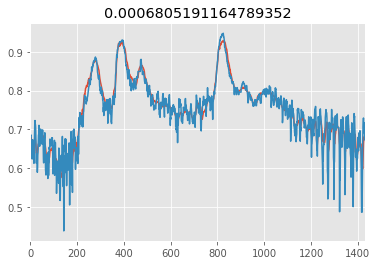

In [92]:
results = pd.DataFrame()
files = glob.glob('../output/predict_csv/*pre_.csv')
for file in [files[0]]:
    df = pd.read_csv(file,index_col=0)
    results[df.columns] = df[df.columns]
results['mean'] = pd.Series(np.mean(results[results.columns[1:]],axis=1))
mse = mean_squared_error(results['mean'],results['real_value'])
results['mean'].plot()
results['real_value'].plot()
plt.title(mse)
plt.show()

In [88]:
glob.glob('output/*pre.csv')

['output/vote_models_pre_.csv',
 'output/bagging_models_pre_.csv',
 'output/linear_models_pre_.csv',
 'output/lstm_models_pre_.csv',
 'output/other_models_pre_.csv',
 'output/tree_based_models_pre_.csv']